## Multi-Class Classification

**This** time, we'll work with 10 different types of food.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

Import Libraries 

In [ ]:
#libraries for project 
import os
import random

# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np

# View an image and import data analysis tools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

#import tensorflow image preprocessing `ImageDataGenerator` class
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

Import Useful Functions 

In [ ]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  #loss metrics
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #accuracy metrics
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure() #needs this call every time you want to create a new plot 
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Process of pre-processing random image to make predictions:

  1.Reads an image from filename
  2.Turns it into a tensor
  3.Reshapes it to (img_shape, img_shape, colour_channel)
  4.Normalizes data (divides RBG tensor info by 255)

  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
def pred_and_plot_binary(model, filename, class_names):
  """
  1.Imports an image located at filename 
  2.Makes a prediction on it with a trained model 
  3.Plots the image with the predicted class as the title
  
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

### 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.


In [ ]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-08-02 21:05:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 142.251.45.16, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   232MB/s    in 2.1s    

2022-08-02 21:05:40 (232 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



Now let's check out all of the different directories and sub-directories in the `10_food_classes` file.

In [ ]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

Looking good!

We'll now setup the training and test directory paths.

In [ ]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

And get the class names from the subdirectories.

In [ ]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
len(class_names), print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


(10, None)

How about we visualize an image from the training set?

Image shape: (512, 382, 3)


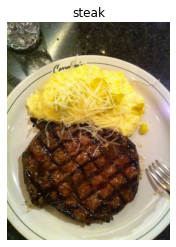

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

## **Preprocess the data (prepare it for a model)**


In [ ]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # default is categorical
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=32,
                                             target_size=(224, 224),
                                             class_mode="categorical",
                                             seed=42)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## **Create Model**

Use same architecture as model_8 in the binary classification CNN module but change the following:

* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* **Output layer:** `'softmax'` instead of `'sigmoid'` activation.
* **Loss function:** `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [ ]:
# Create a CNN model 
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') #change sigmoid to softmax for >2 classes 
])      #change output layer to # of classess (e.g. 10)

# Compile the model
model_1.compile(loss="categorical_crossentropy", #chnage to categorical_crossentropy for  multi-class problems
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 47s 197ms/step - loss: 2.2424 - accuracy: 0.1516 - val_loss: 2.1714 - val_accuracy: 0.1812
Epoch 2/5
235/235 [==============================] - 46s 194ms/step - loss: 1.9818 - accuracy: 0.3044 - val_loss: 1.9378 - val_accuracy: 0.3040
Epoch 3/5
235/235 [==============================] - 49s 209ms/step - loss: 1.5715 - accuracy: 0.4732 - val_loss: 2.1526 - val_accuracy: 0.2692
Epoch 4/5
235/235 [==============================] - 45s 192ms/step - loss: 0.9133 - accuracy: 0.7057 - val_loss: 2.5992 - val_accuracy: 0.2684
Epoch 5/5
235/235 [==============================] - 46s 198ms/step - loss: 0.2967 - accuracy: 0.9089 - val_loss: 3.8104 - val_accuracy: 0.2388


## **Evaluate Model**

In [ ]:
#Evaluate model
model_1.evaluate(test_data)

79/79 [==============================] - 11s 143ms/step - loss: 3.8104 - accuracy: 0.2388


[3.8104374408721924, 0.23880000412464142]

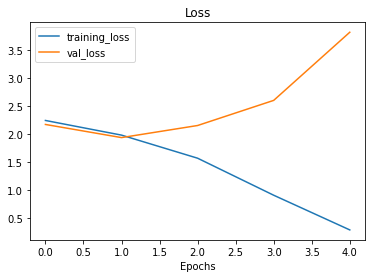

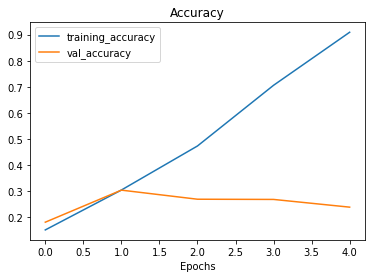

In [ ]:
# Check out the loss curves of model_1
plot_loss_curves(history_1)

In [ ]:
# Check out our model's architecture
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_33 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_35 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

### Adjust the model parameters

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

> 🔑 **Note:** Preventing overfitting is also referred to as **regularization**.



In [ ]:
# Try a simplified model (removed two layers)
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 49s 206ms/step - loss: 2.1450 - accuracy: 0.2421 - val_loss: 2.0275 - val_accuracy: 0.2840
Epoch 2/5
235/235 [==============================] - 44s 187ms/step - loss: 1.8367 - accuracy: 0.3628 - val_loss: 1.9018 - val_accuracy: 0.3272
Epoch 3/5
235/235 [==============================] - 44s 187ms/step - loss: 1.6182 - accuracy: 0.4529 - val_loss: 1.8431 - val_accuracy: 0.3640
Epoch 4/5
235/235 [==============================] - 43s 183ms/step - loss: 1.2744 - accuracy: 0.5860 - val_loss: 2.0237 - val_accuracy: 0.3424
Epoch 5/5
235/235 [==============================] - 44s 185ms/step - loss: 0.8565 - accuracy: 0.7341 - val_loss: 2.2519 - val_accuracy: 0.3176


In [ ]:
# Check out our model's architecture
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 29160)             0         
                                                                 
 dense_9 (Dense)             (None, 10)               

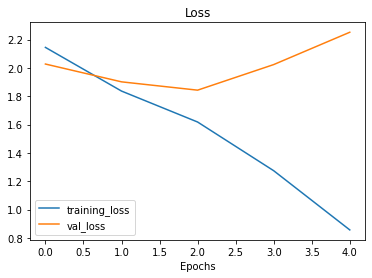

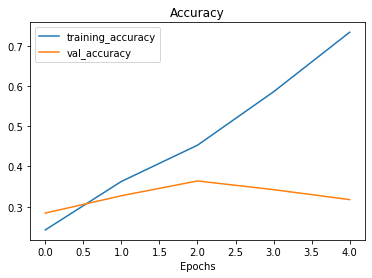

In [ ]:
# Check out the loss curves of model_2
plot_loss_curves(history_2)

Even with a simplifed model, it looks like our model is still dramatically overfitting the training data.What else could we try?

How about **data augmentation**?

To create augmented data, we'll recreate a new [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

In [ ]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical')

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model that we instantiated previously.

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) which can take an existing model and rebuild it in the same format. 

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

> 🔑 **Note:** One of the key practices in deep learning and machine learning in general is to **be a serial experimenter**. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [ ]:
# Clone the model (use the same architecture)
model_3 = tf.keras.models.clone_model(model_2)

# Compile the cloned model (same setup as used for model_10)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 110s 468ms/step - loss: 2.2092 - accuracy: 0.1855 - val_loss: 2.0269 - val_accuracy: 0.2768
Epoch 2/5
235/235 [==============================] - 113s 479ms/step - loss: 2.0461 - accuracy: 0.2771 - val_loss: 1.8838 - val_accuracy: 0.3620
Epoch 3/5
235/235 [==============================] - 109s 463ms/step - loss: 1.9734 - accuracy: 0.3133 - val_loss: 1.8677 - val_accuracy: 0.3508
Epoch 4/5
235/235 [==============================] - 109s 465ms/step - loss: 1.9450 - accuracy: 0.3269 - val_loss: 1.7949 - val_accuracy: 0.3788
Epoch 5/5
235/235 [==============================] - 109s 463ms/step - loss: 1.8946 - accuracy: 0.3393 - val_loss: 1.7542 - val_accuracy: 0.3988


In [ ]:
# Check out our model's architecture
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 29160)             0         
                                                                 
 dense_9 (Dense)             (None, 10)               

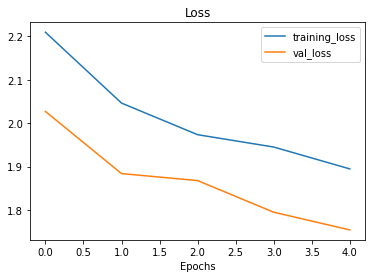

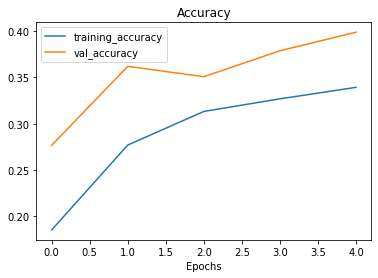

In [ ]:
# Check out our model's performance with augmented data
plot_loss_curves(history_3)

### Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

## Making a prediction with our trained model


In [ ]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

Okay, we've got some custom images to try, let's use the `pred_and_plot` function to make a prediction with `model_3` on one of the images and plot it.

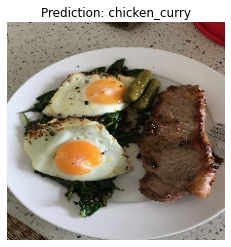

In [ ]:
# Make a prediction using model_11
pred_and_plot(model=model_3, 
              filename="03-steak.jpeg", 
              class_names=class_names)

Hmm... it looks like our model got the prediction wrong, how about we try another?

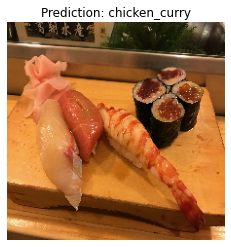

In [ ]:
pred_and_plot(model_3, "03-sushi.jpeg", class_names)

And again, it's predicting `chicken_curry` for some reason.

How about one more?

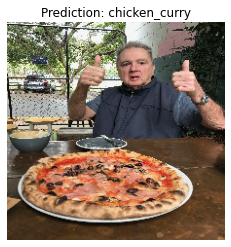

In [ ]:
pred_and_plot(model_3, "03-pizza-dad.jpeg", class_names)

`chicken_curry` again? There must be something wrong...

I think it might have to do with our `pred_and_plot` function.

Let's makes a prediction without using the function and see where it might be going wrong.

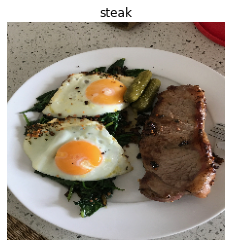

In [ ]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_3.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Much better! There must be something up with our `pred_and_plot` function.

And I think I know what it is.

The `pred_and_plot` function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the `predict` function.

In [ ]:
# Check the output of the predict function
pred = model_3.predict(tf.expand_dims(img, axis=0))
pred

array([[0.03167158, 0.08185729, 0.05308107, 0.08086763, 0.12408097,
        0.1290936 , 0.05679378, 0.04934147, 0.22392747, 0.16928515]],
      dtype=float32)

Since our model has a `'softmax'` activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) and then use that to index our `class_names` list to output the predicted class.

In [ ]:
# Find the predicted class name
class_names[pred.argmax()]

'steak'

Knowing this, we can readjust our `pred_and_plot` function to work with multiple classes as well as binary classes.

In [ ]:
# Adjust function to work with multi-class
def pred_and_plot_multiclass(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Let's try it out. If we've done it right, using different images should lead to different outputs (rather than `chicken_curry` every time).

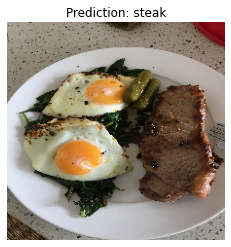

In [ ]:
pred_and_plot_multiclass(model_3, "03-steak.jpeg", class_names)

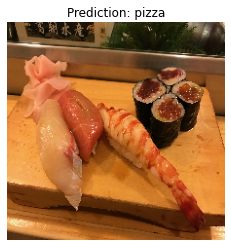

In [ ]:
pred_and_plot_multiclass(model_3, "03-sushi.jpeg", class_names)

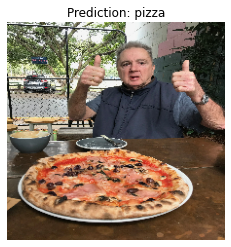

In [ ]:
pred_and_plot_multiclass(model_3, "03-pizza-dad.jpeg", class_names)

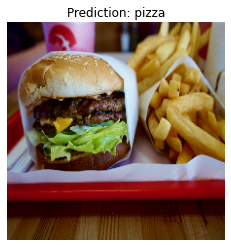

In [ ]:
pred_and_plot_multiclass(model_3, "03-hamburger.jpeg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~40% accuracy on the test dataset.

## Saving and loading our model

Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the [`save`](https://www.tensorflow.org/tutorials/keras/save_and_load) and [`load_model`](https://www.tensorflow.org/tutorials/keras/save_and_load) functions.

In [ ]:
# Save a model
model_3.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


INFO:tensorflow:Assets written to: saved_trained_model/assets


In [ ]:
# Load in a model and evaluate it
loaded_model_3 = tf.keras.models.load_model("saved_trained_model")
loaded_model_3.evaluate(test_data)

79/79 [==============================] - 11s 141ms/step - loss: 1.7542 - accuracy: 0.3988


[1.7541660070419312, 0.39879998564720154]

In [ ]:
# Compare our unsaved model's results (same as above)
model_3.evaluate(test_data)

79/79 [==============================] - 12s 145ms/step - loss: 1.7542 - accuracy: 0.3988


[1.7541656494140625, 0.39879998564720154]

## 🛠 Exercises

1. Spend 20-minutes reading and interacting with the [CNN explainer website](https://poloclub.github.io/cnn-explainer/). 
 * What are the key terms? e.g. explain convolution in your own words, pooling in your own words

2. Play around with the "understanding hyperparameters" section in the [CNN explainer](https://poloclub.github.io/cnn-explainer/) website for 10-minutes.
  * What is the kernel size?
  * What is the stride? 
  * How could you adjust each of these in TensorFlow code?

3. Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.

4. Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.

## 📖 Extra-curriculum

1. **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.

2. **Watch:** Deep dive on [mini-batch gradient descent](https://youtu.be/-_4Zi8fCZO4) by deeplearning.ai. If you're still curious about why we use **batches** to train models, this technical overview covers many of the reasons why.

3. **Read:** [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/) class notes. This will give a very deep understanding of what's going on behind the scenes of the convolutional neural network architectures we're writing. 

4. **Read:** ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf). This paper goes through all of the mathematics running behind the scenes of our convolutional layers.

5. **Code practice:** [TensorFlow Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). For a more in-depth introduction on data augmentation with TensorFlow, spend an hour or two reading through this tutorial.